## Import Necessary Libraries

In [20]:
import io
import itertools
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, roc_auc_score)
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS
from matplotlib.pyplot import subplots

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import log_loss, f1_score, roc_auc_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

## Load the Red Wine data

In [2]:
wine = pd.read_csv('/Users/sophiamei/Desktop/QTM 347/Wine-Quality-Prediction/Data/winequality-red.csv', delimiter = ';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Check Data Types

Note: we change the data type of `quality` to categorical variable for classfication task.

In [ ]:
wine['quality'] = wine['quality'].astype('category')

print("\nData Types:")
print(wine.dtypes)


Data Types:
fixed acidity            float64
volatile acidity         float64
citric acid              float64
residual sugar           float64
chlorides                float64
free sulfur dioxide      float64
total sulfur dioxide     float64
density                  float64
pH                       float64
sulphates                float64
alcohol                  float64
quality                 category
dtype: object


### Check for missing data

In [ ]:
print("\nMissing Data:")
print(wine.isnull().sum())


Missing Data:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


## Exploratory Data Analysis

### a. Histograms of Feature Distribution

<Figure size 1500x1000 with 0 Axes>

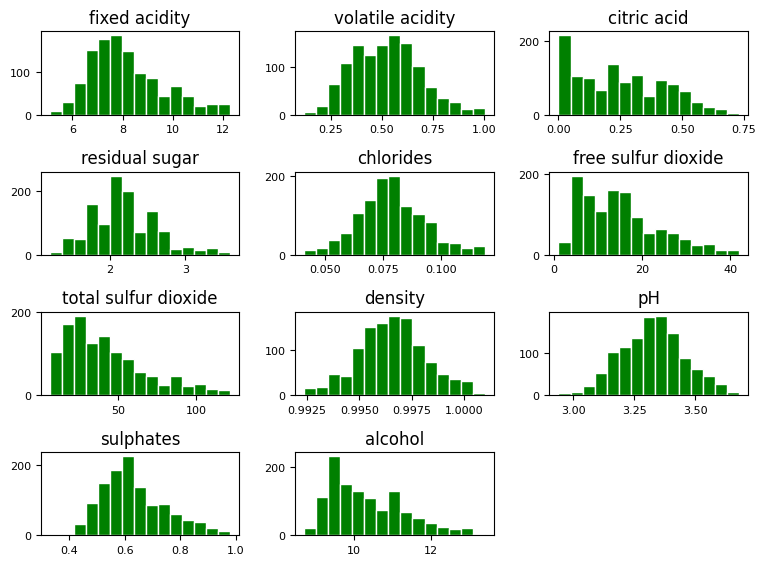

In [ ]:
plt.figure(figsize=(15, 10))
wine.hist(bins=15, color='green', edgecolor='white', linewidth=1.0,
               xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

### b. Pair Plot of Correlation Between Variables


Text(0.5, 1.02, 'Pair Plot of Wine Data')

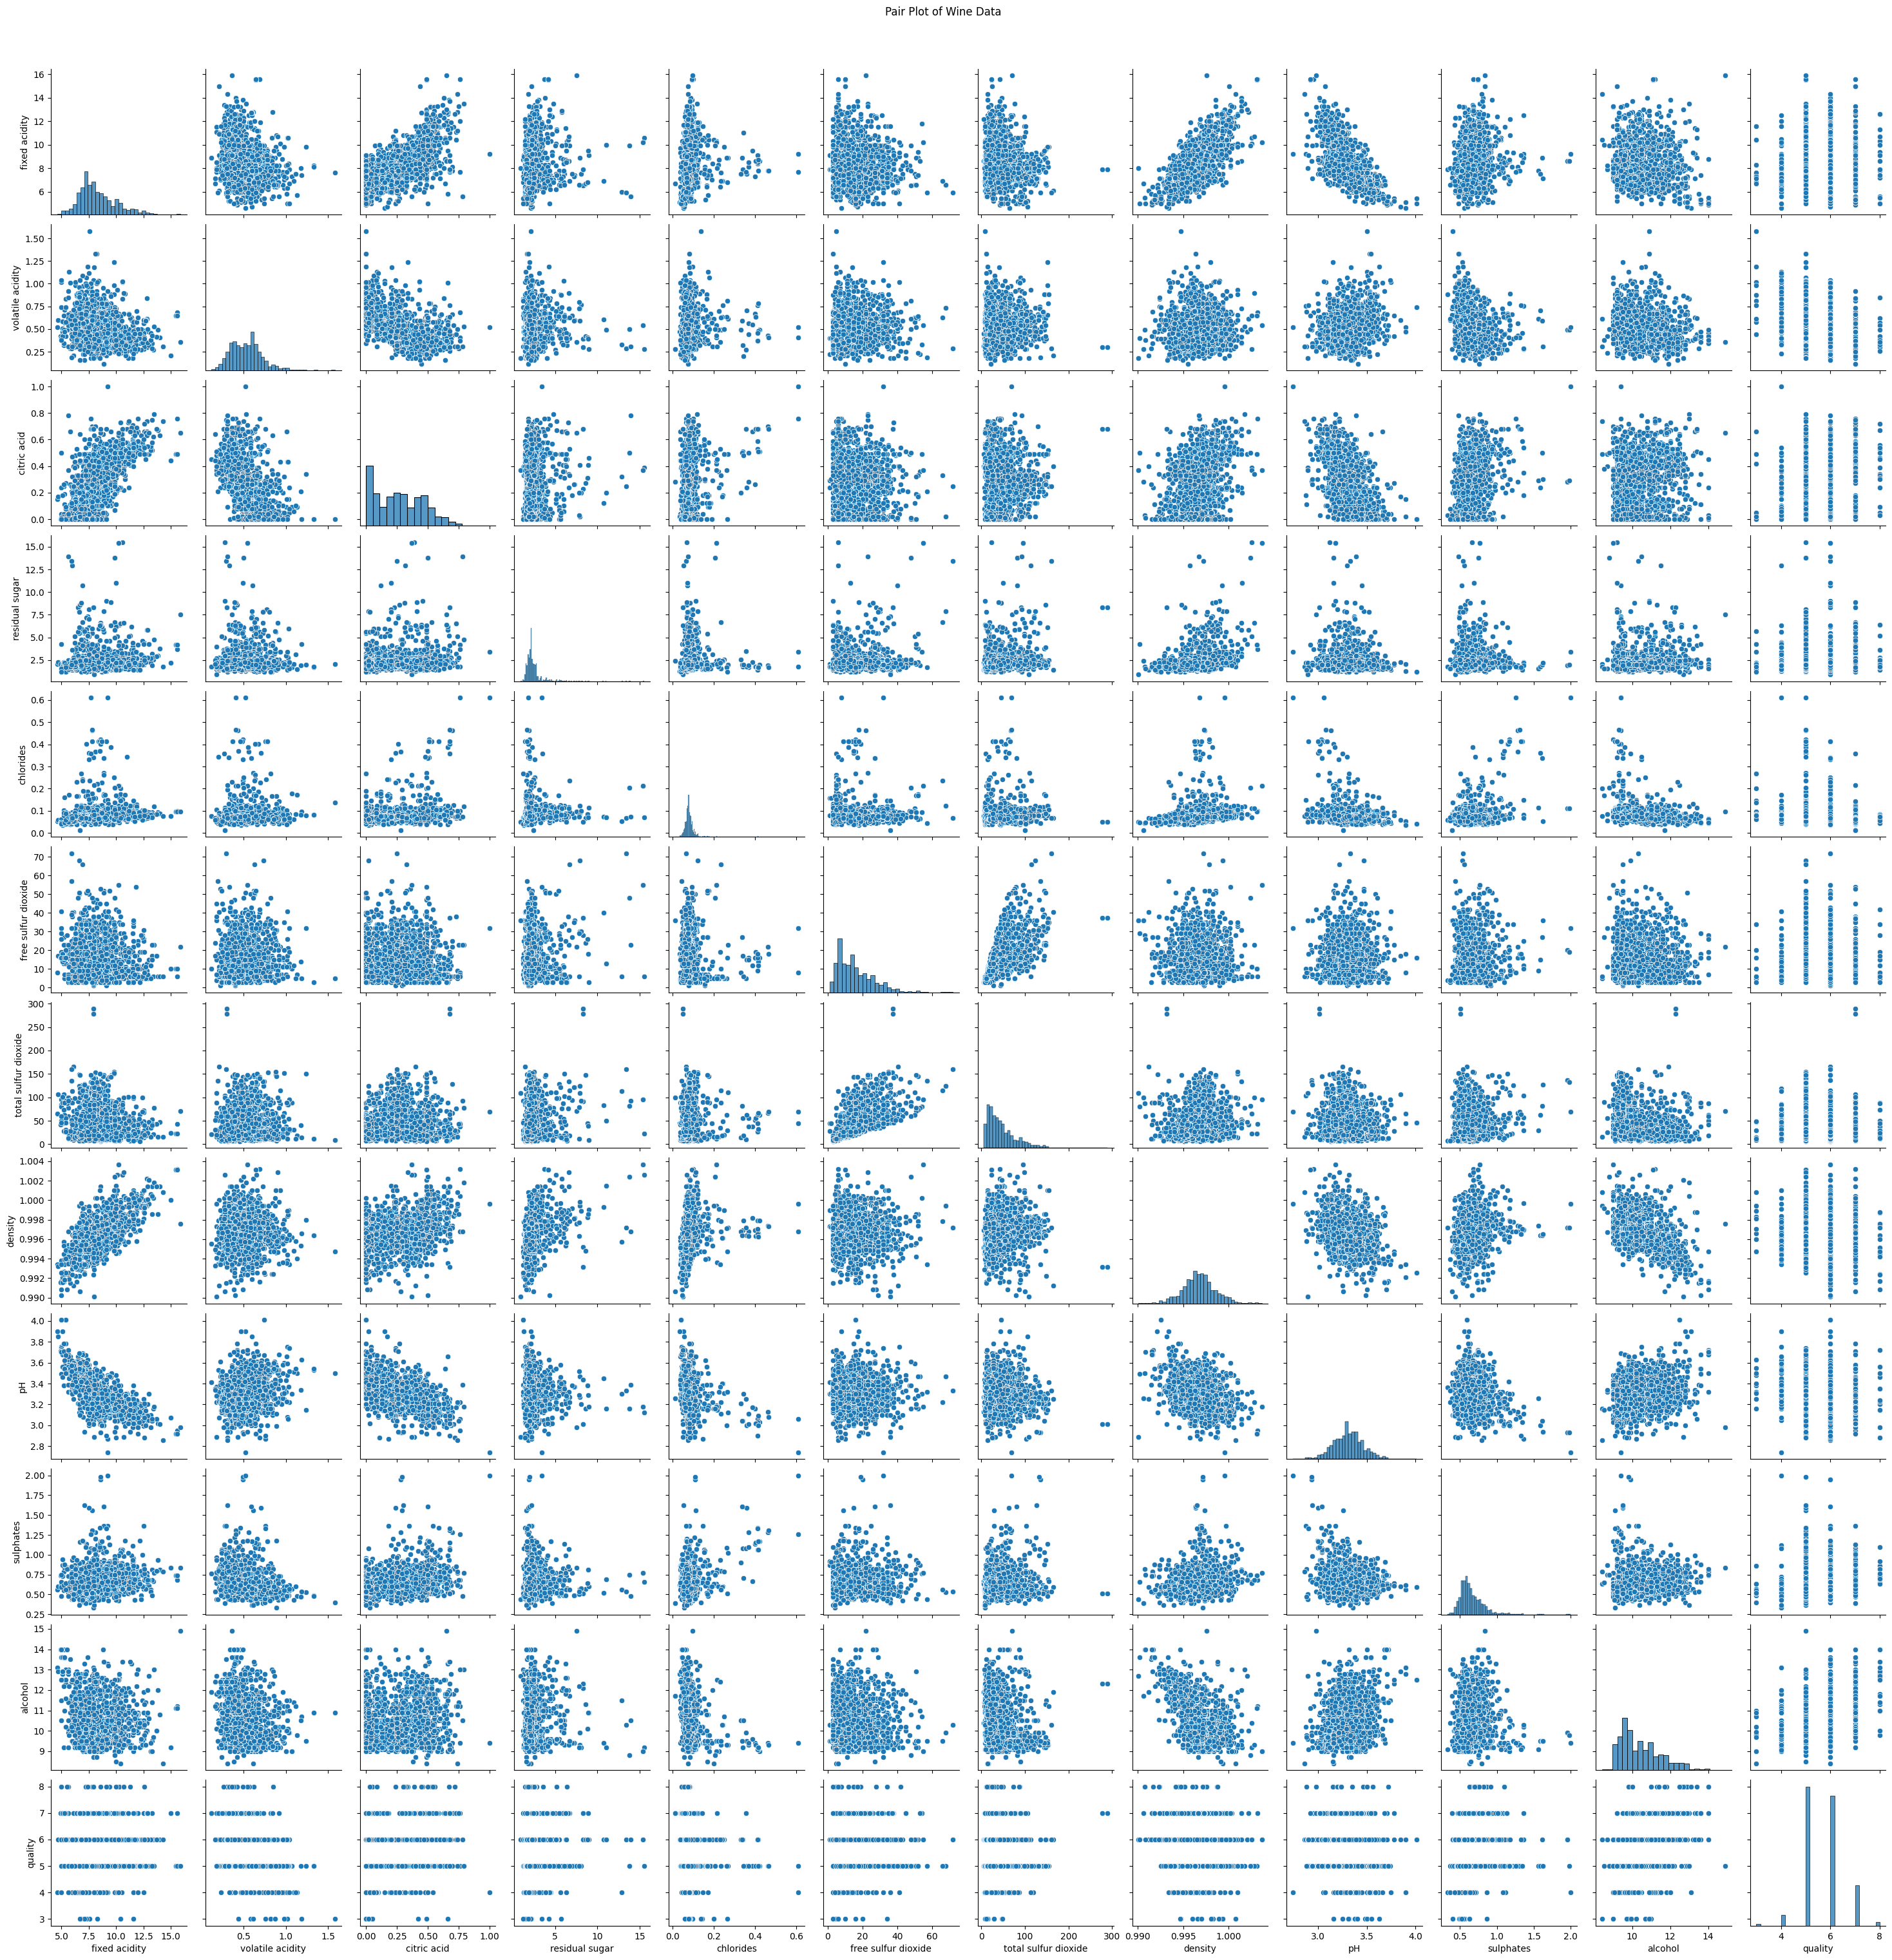

In [ ]:
sns.pairplot(wine, kind='scatter', diag_kind='hist')
plt.suptitle('Pair Plot of Wine Data', y=1.02)

### c. Correlation Heatmap

Text(0.5, 1.0, 'Correlation of Wine Attributes')

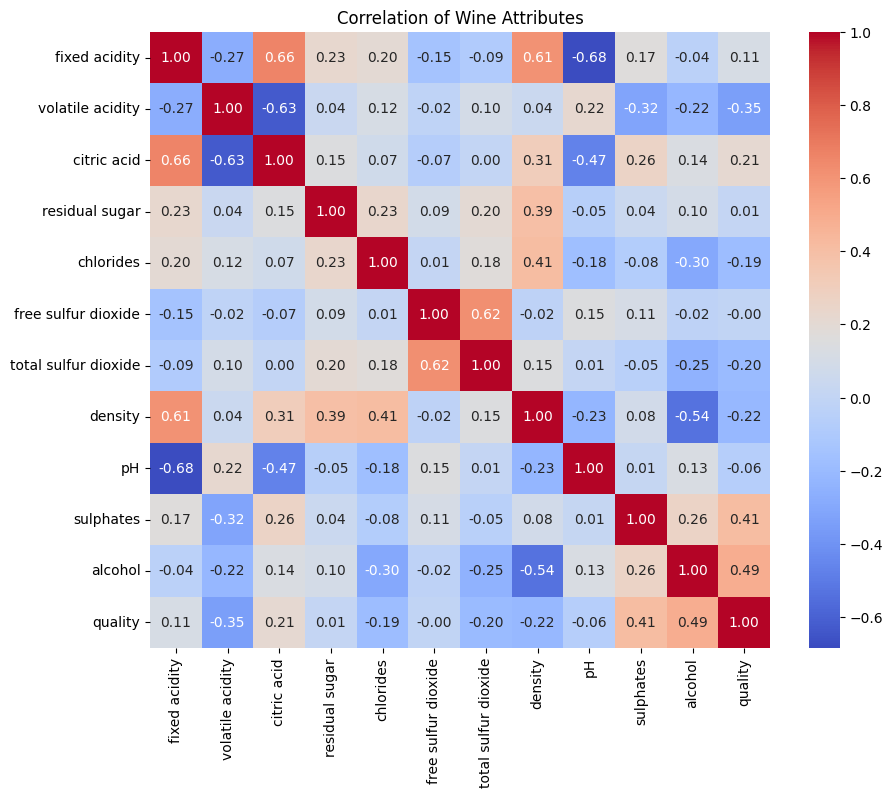

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(wine.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation of Wine Attributes')

The attribute alcohol shows the strongest positive correlation with quality (0.48), implying that higher alcohol content may be associated with higher wine quality. In contrast, volatile acidity shows a relatively strong negative correlation with quality (-0.39), suggesting that wines with lower volatile acidity are often of higher quality.

Attributes like citric acid, sulphates, and fixed acidity show a small positive correlation with quality, indicating that these factors might play a role in enhancing the wine's quality, but the relationship is not as pronounced as with alcohol.

Conversely, density and chlorides are negatively correlated with quality, though to a lesser extent, hinting that wines with lower density and chlorides might be perceived as higher in quality.

### d. Subplots for Feature Relationships Against Quality

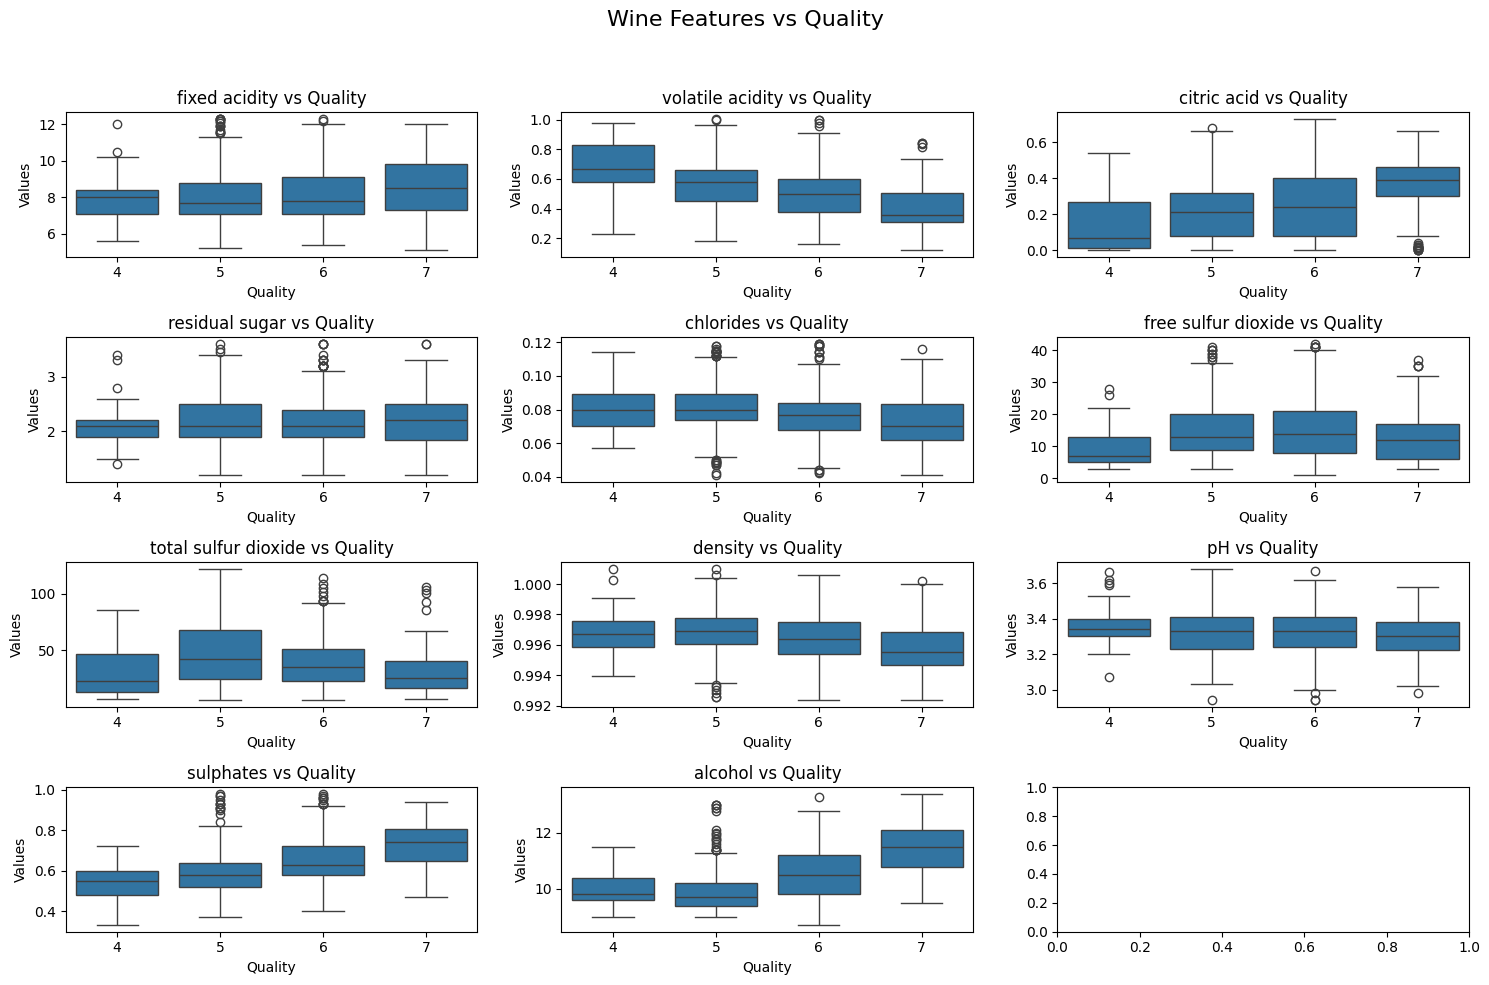

In [ ]:
num_rows, num_cols = 4, 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle('Wine Features vs Quality', fontsize=16)

for index, feature in enumerate(wine.columns[:-1]):
    row, col = index // num_cols, index % num_cols
    sns.boxplot(x='quality', y=feature, data=wine, ax=axs[row, col])
    axs[row, col].set_ylabel('Values')
    axs[row, col].set_xlabel('Quality')
    axs[row, col].set_title(f'{feature} vs Quality')

plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.show()

### e. Boxplots for Outliers Detection

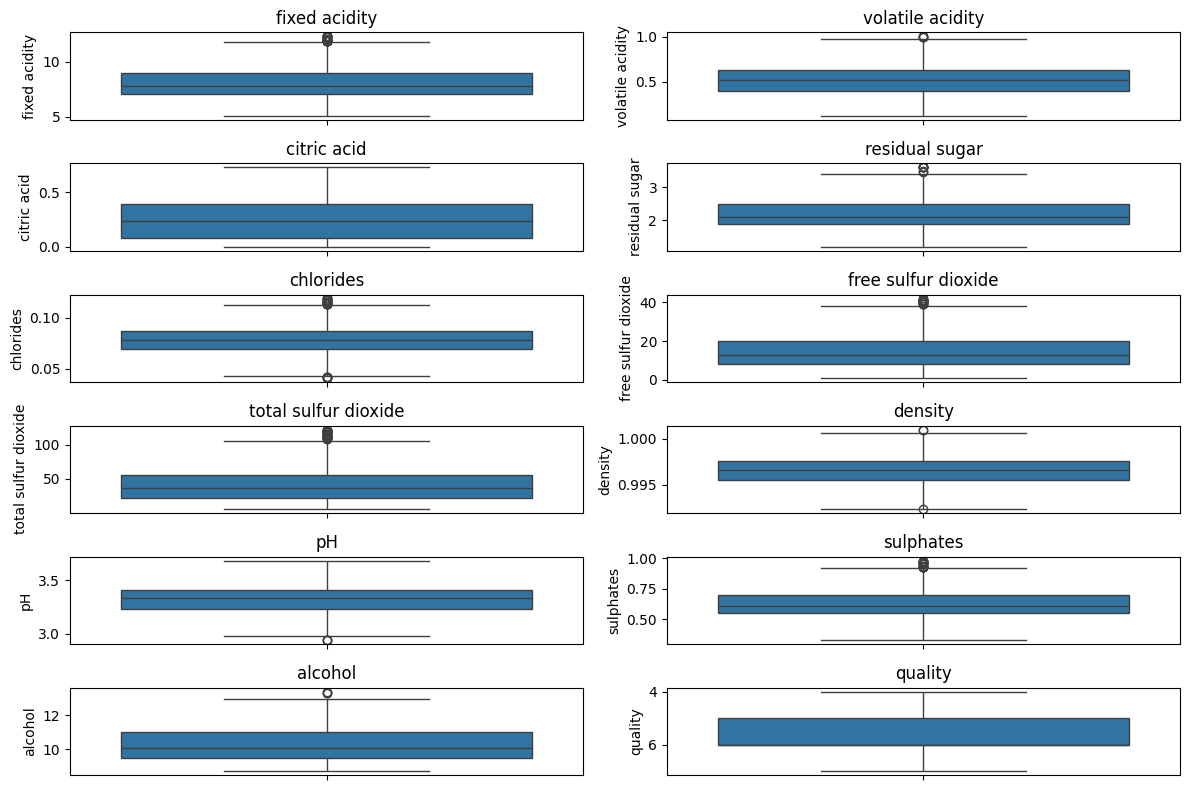

In [ ]:
plt.figure(figsize=(12, 8))
for index, column in enumerate(wine.columns):
    plt.subplot((len(wine.columns) + 1) // 2, 2, index + 1)
    sns.boxplot(y=wine[column])
    plt.title(column)
plt.tight_layout()
plt.show()

## Data Preprocessing

### a. Outlier Removal

In [3]:
Q1 = wine.quantile(0.25)
Q3 = wine.quantile(0.75)
IQR = Q3 - Q1
feature_columns = wine.columns[wine.columns != 'quality']

# Define the acceptable range (Criteria: 1.5 * IQR below Q1 and above Q3)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
wine_cleaned = wine[~((wine[feature_columns] < lower_bound[feature_columns]) |
                      (wine[feature_columns] > upper_bound[feature_columns])).any(axis=1)]

# Print the cleaned data
print(wine_cleaned.describe())
wine = wine_cleaned

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1194.000000       1194.000000  1194.000000     1194.000000   
mean        8.166583          0.522735     0.248124        2.185762   
std         1.461136          0.164879     0.180208        0.442160   
min         5.100000          0.120000     0.000000        1.200000   
25%         7.100000          0.390000     0.080000        1.900000   
50%         7.800000          0.520000     0.240000        2.100000   
75%         9.000000          0.630000     0.390000        2.500000   
max        12.300000          1.005000     0.730000        3.600000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1194.000000          1194.000000           1194.000000  1194.000000   
mean      0.078477            15.005863             42.154941     0.996571   
std       0.014300             8.819079             26.084786     0.001604   
min       0.041000             1.000000         

### b. Train-Test Split (80/20 ratio)

In [4]:
train, test = train_test_split(wine, test_size = 0.2, random_state = 0)

In [5]:
X_train = train.drop(['quality'], axis=1)
y_train = train['quality']

X_test = test.drop(['quality'], axis=1)
y_test = test['quality']

## Model I. Logistic Regression + Best Subset Selection

### Best Subset Selection

In [ ]:
# This is only for ignoring warnings purpose
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UserWarning, message="The least populated class in y has only 3 members, which is less than n_splits=*")

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

def processSubset(feature_set):
    scaler = StandardScaler()
    log_reg = LogisticRegression(random_state=0, max_iter=10000)
    # Use Stratified K-Fold to maintain balanced ratio of classes in each fold
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
    pipe = Pipeline([('scaler', scaler), ('log_reg', log_reg)])
    scores = cross_val_score(pipe, X_train[list(feature_set)], y_train, cv=skf, scoring='accuracy')
    return {"model": pipe, "score": np.mean(scores), "features": feature_set}

def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X_train.columns, k):
        results.append(processSubset(combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['score'].idxmax()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", toc - tic, "seconds.")

    return best_model

# Run model with cross-validation
models_cv = pd.DataFrame(columns=["score", "model", "features"])
tic = time.time()
for i in range(1, len(X_train.columns) + 1):
    models_cv.loc[i] = getBest(i)
toc = time.time()

Processed 12 models on 1 predictors in 2.5348873138427734 seconds.
Processed 66 models on 2 predictors in 7.3059422969818115 seconds.
Processed 220 models on 3 predictors in 23.650492191314697 seconds.
Processed 495 models on 4 predictors in 56.71780705451965 seconds.
Processed 792 models on 5 predictors in 98.09047365188599 seconds.
Processed 924 models on 6 predictors in 125.72438764572144 seconds.
Processed 792 models on 7 predictors in 132.30808901786804 seconds.
Processed 495 models on 8 predictors in 72.00859045982361 seconds.
Processed 220 models on 9 predictors in 34.7162766456604 seconds.
Processed 66 models on 10 predictors in 10.927842855453491 seconds.
Processed 12 models on 11 predictors in 2.0015928745269775 seconds.
Processed 1 models on 12 predictors in 0.16971731185913086 seconds.


In [ ]:
# Output the best subset of features
models_cv['score'] = pd.to_numeric(models_cv['score'], errors='coerce')
best_index = models_cv['score'].idxmax()
best_model = models_cv.loc[best_index]

print("Best features:", best_model['features'])

Best features: ('fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol')


### Predictive Model

In [ ]:
predictors_bs = list(best_model['features'])

scaler = StandardScaler()
log_reg = LogisticRegression(random_state=0, max_iter=10000)
pipe = Pipeline([('scaler', scaler), ('log_reg', log_reg)])
pipe.fit(X_train[predictors_bs], y_train)

train_pred = pipe.predict(X_train[predictors_bs])
test_pred = pipe.predict(X_test[predictors_bs])

### Performance Metrics

In [ ]:
# This is just for ignoring warnings purpose
import warnings
warnings.filterwarnings('ignore', message='Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.')

print("Training Data Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, train_pred))
print("\nClassification Report:")
print(classification_report(y_train, train_pred))

print("Testing Data Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_pred))
print("\nClassification Report:")
print(classification_report(y_test, test_pred))

Training Data Metrics:
Confusion Matrix:
[[  0   0   3   0   0   0]
 [  0   1  20   7   0   0]
 [  0   0 296 111   0   0]
 [  0   0 122 263  17   0]
 [  0   0   4  68  34   0]
 [  0   0   0   7   2   0]]

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       1.00      0.04      0.07        28
           5       0.67      0.73      0.69       407
           6       0.58      0.65      0.61       402
           7       0.64      0.32      0.43       106
           8       0.00      0.00      0.00         9

    accuracy                           0.62       955
   macro avg       0.48      0.29      0.30       955
weighted avg       0.63      0.62      0.60       955

Testing Data Metrics:
Confusion Matrix:
[[ 0  4  1  0  0]
 [ 0 83 23  0  0]
 [ 0 29 62  5  0]
 [ 0  2 14 13  0]
 [ 0  0  1  2  0]]

Classification Report:
              precision    recall  f1-score   support

           4       

## Model II. Random Forests Classifier

### Predictive Model

In [6]:
model = MS(wine.columns.drop('quality'), intercept=False) 

In [7]:
D = model.fit_transform(wine)
feature_names = list(D.columns)
X = np.asarray(D)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ISLP/models/columns.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:


Preliminary Model

In [8]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', metrics.accuracy_score(y_test,y_pred))

Accuracy:  0.7280334728033473


In [10]:
feature_imp = pd.Series(clf.feature_importances_, index=wine.columns[:11]).sort_values(ascending=False)
feature_imp

alcohol                 0.134843
sulphates               0.119015
volatile acidity        0.108327
total sulfur dioxide    0.100531
density                 0.092245
chlorides               0.088217
citric acid             0.081271
fixed acidity           0.074783
pH                      0.074542
free sulfur dioxide     0.065237
residual sugar          0.060988
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


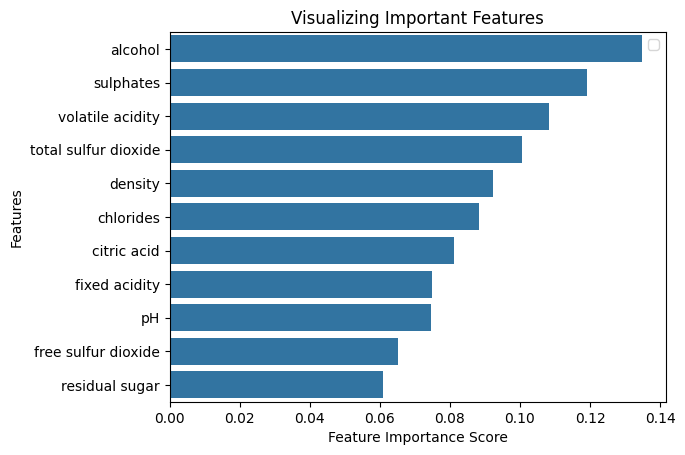

In [12]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Model Tuning

In [13]:
rf = RandomForestClassifier(random_state = 0)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 14, num = 7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [16]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.0s
[CV] END bootstrap=False, max_depth=14, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.0s
[CV] END bootstrap=False, max_depth=14,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
209 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

Best Parameters

In [17]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

### Performance Metrics

In [18]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 0)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test,y_test)

Model Performance
Average Error: 0.3556 degrees.
Accuracy = 93.87%.


In [22]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.6192 degrees.
Accuracy = 89.13%.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [23]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 0  4  1  0  0]
 [ 1 77 26  1  1]
 [ 0 25 61 10  0]
 [ 0  2 15 12  0]
 [ 0  1  1  1  0]]

Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         5
           5       0.71      0.73      0.72       106
           6       0.59      0.64      0.61        96
           7       0.50      0.41      0.45        29
           8       0.00      0.00      0.00         3

    accuracy                           0.63       239
   macro avg       0.36      0.36      0.36       239
weighted avg       0.61      0.63      0.62       239



## Model III. K-Nearest Neighbors (KNN)


### Predictive Model

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

### Performance Metrics

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))